In [1]:
import sys
sys.path.append("../scripts/")
from robot import *

In [2]:
class Particle:
    def __init__(self, init_pose):
        self.pose = init_pose

In [3]:
class Mcl:
    def __init__(self, init_pose, num):
        self.particles = [Particle(init_pose) for i in range(num)]
        
    def draw(self, ax, elems):
        xs = [p.pose[0] for p in self.particles]
        xy = [p.pose[1] for p in self.particles]
        vxs = [math.cos(p.pose[2]) for p in self.particles]
        vxy = [math.sin(p.pose[2]) for p in self.particles]
        elems.append(ax, ruiver(xs, ys, vxs, vys, color="blue", alpha=0.5))

In [4]:
class EstimationAgent(Agent):
    def __init__(self, nu, omega, estimator):
        super().__init__(nu, omega)
        self.estimator = estimator
        
    def draw(self, ax, elems):
        self.esitimator.draw(ax, elems)

<IPython.core.display.Javascript object>


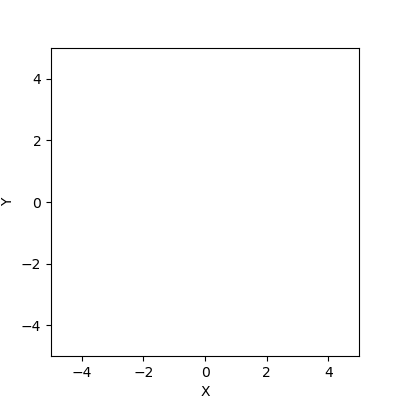

In [5]:
world = World(30, 0.1, debug=False)

m = Map()
for ln in [(-4, 2), (2, -3), (3, 3)]: m.append_landmark(Landmark(*ln))
world.append(m)

initial_pose = np.array([2, 2, math.pi/6]).T
estimator = Mcl(initial_pose, 100)
circling = EstimationAgent(0.2, 10.0/180*math.pi, estimator)
r = Robot(initial_pose, sensor=Camera(m), agent=circling)
world.append(r)

world.draw()